<a href="https://colab.research.google.com/github/exactful/long-short-term-memory-networks/blob/main/daily_delhi_climate_time_series_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Predicting temp with LSTM and Daily Delhi Climate time series data**

This notebook builds an LSTM model and then uses that model to predict the monthly mean temperature for the next 36 months.  Each monthly prediction relies on the previous 9 monthly temperatures.  The first prediction uses the last 9 values from the train dataset, the next prediction uses the last 8 values + first prediction, the next uses the last seven values + first 2 predictions and so on.  Eventually, we have predictions being made on previous predictions only.  Plenty of scope for hyperparameter tuning and cross validation during fitting but not included here.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Load data
train_raw = pd.read_csv("/content/DailyDelhiClimateTrain.csv",index_col="date",parse_dates=True)
train_raw.index.freq = "D"

test_raw = pd.read_csv("/content/DailyDelhiClimateTest.csv",index_col="date",parse_dates=True)
test_raw.index.freq = "D"

In [ ]:
# Downsample to monthly means
train = train_raw[["meantemp"]].resample("M").mean()
test = test_raw[["meantemp"]].resample("M").mean()

# Upsample back to daily with linear interpolation
# ...resample("D").interpolate(method="linear")

# Or upsample back to daily with monthly mean used for each data point
# ...resample("D").ffill()

# Or just using a rolling 30-day mean
# ...rolling(30).mean()

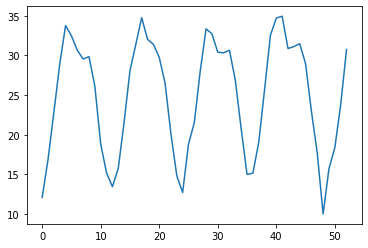

In [ ]:
# Plot train and test data
plt.plot(np.append(train, test))

In [ ]:
# Scale data - fit around train and then transform both train and test
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(train)
train_scaled = scaler.transform(train)
#val_scaled = scaler.transform(val) # Could experiment with cross validation
test_scaled = scaler.transform(test)

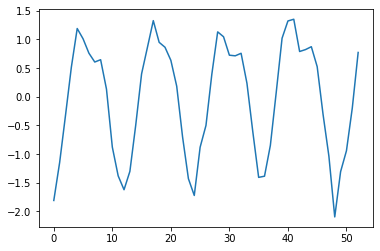

In [ ]:
# Plot scaled train and test data
plt.plot(np.append(train_scaled, test_scaled))

In [ ]:
# Define generator that provides n_input data points at a time (e.g. rolling n_input months)
from keras.preprocessing.sequence import TimeseriesGenerator
n_input = 9 # Also try 3, 6, 9, 12...
n_features = 1
generator = TimeseriesGenerator(train_scaled, train_scaled, length=n_input, batch_size=1)
#generator_val = TimeseriesGenerator(val_scaled, val_scaled, length=n_input, batch_size=1) # Not used

In [ ]:
# Define model
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(128, activation="relu", return_sequences=True, input_shape=(n_input, n_features)))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mse", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 9, 128)            66560     
                                                                 
 dropout (Dropout)           (None, 9, 128)            0         
                                                                 
 lstm_1 (LSTM)               (None, 9, 128)            131584    
                                                                 
 dropout_1 (Dropout)         (None, 9, 128)            0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 25)                1

In [ ]:
# Fit model
history = model.fit(generator, epochs=50) #, validation_data=generator_val)

Epoch 1/50
40/40 [==============================] - 6s 15ms/step - loss: 0.6616 - accuracy: 0.0000e+00
Epoch 2/50
40/40 [==============================] - 1s 17ms/step - loss: 0.4779 - accuracy: 0.0000e+00
Epoch 3/50
40/40 [==============================] - 1s 15ms/step - loss: 0.4097 - accuracy: 0.0000e+00
Epoch 4/50
40/40 [==============================] - 1s 15ms/step - loss: 0.2657 - accuracy: 0.0000e+00
Epoch 5/50
40/40 [==============================] - 1s 14ms/step - loss: 0.1869 - accuracy: 0.0000e+00
Epoch 6/50
40/40 [==============================] - 1s 15ms/step - loss: 0.1972 - accuracy: 0.0000e+00
Epoch 7/50
40/40 [==============================] - 1s 17ms/step - loss: 0.3364 - accuracy: 0.0000e+00
Epoch 8/50
40/40 [==============================] - 1s 15ms/step - loss: 0.1637 - accuracy: 0.0000e+00
Epoch 9/50
40/40 [==============================] - 1s 14ms/step - loss: 0.2063 - accuracy: 0.0000e+00
Epoch 10/50
40/40 [==============================] - 1s 16ms/step - loss:

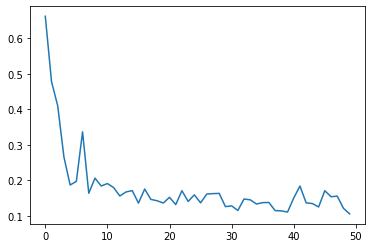

In [ ]:
# Plot loss
loss_per_epoch = model.history.history["loss"]
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

In [ ]:
# Predict
predictions_scaled = []

# Start with the last n_input data points from train_scaled
first_eval_batch = train_scaled[-n_input:]

# Create current batch with shape 1 x n_input x n_features
current_batch = first_eval_batch.reshape((1, n_input, n_features))

# Predict values over next n_months months
n_months = 36

for i in range(n_months):
  
  # Get the first prediction value based on the current batch (which contains the last n_input months)
  current_pred = model.predict(current_batch)[0]
  
  # Store this value in our predictions list
  predictions_scaled.append(current_pred) 
  
  # Add this value to the end of the current batch and remove the first value (e.g. rolling n_input months)
  current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [ ]:
# Unscale the predictions
predictions = scaler.inverse_transform(predictions_scaled)

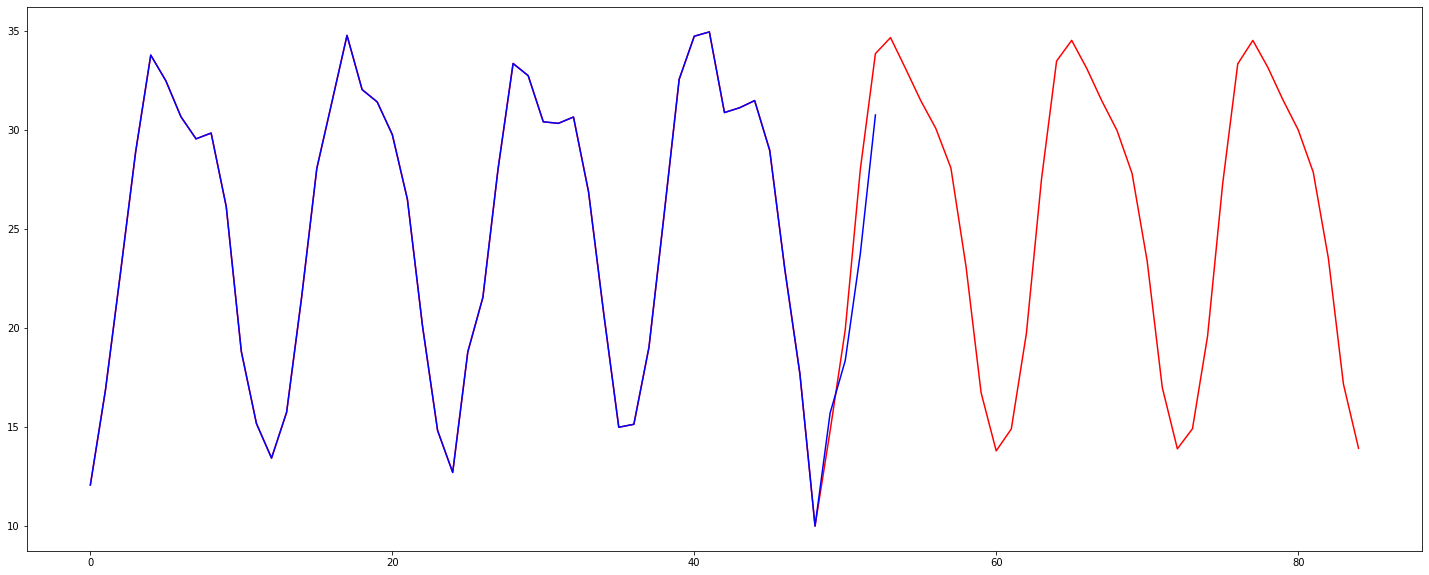

In [ ]:
# Plot train+predictions (red) vs train+test (blue)
# Predictions rely only on the last n_input months of train data; beyond that, the predictions are fed back into the model to make new predictions
plt.figure(figsize=(25,10))
plt.plot(np.append(train, predictions), color="red")
plt.plot(np.append(train, test), color="blue")

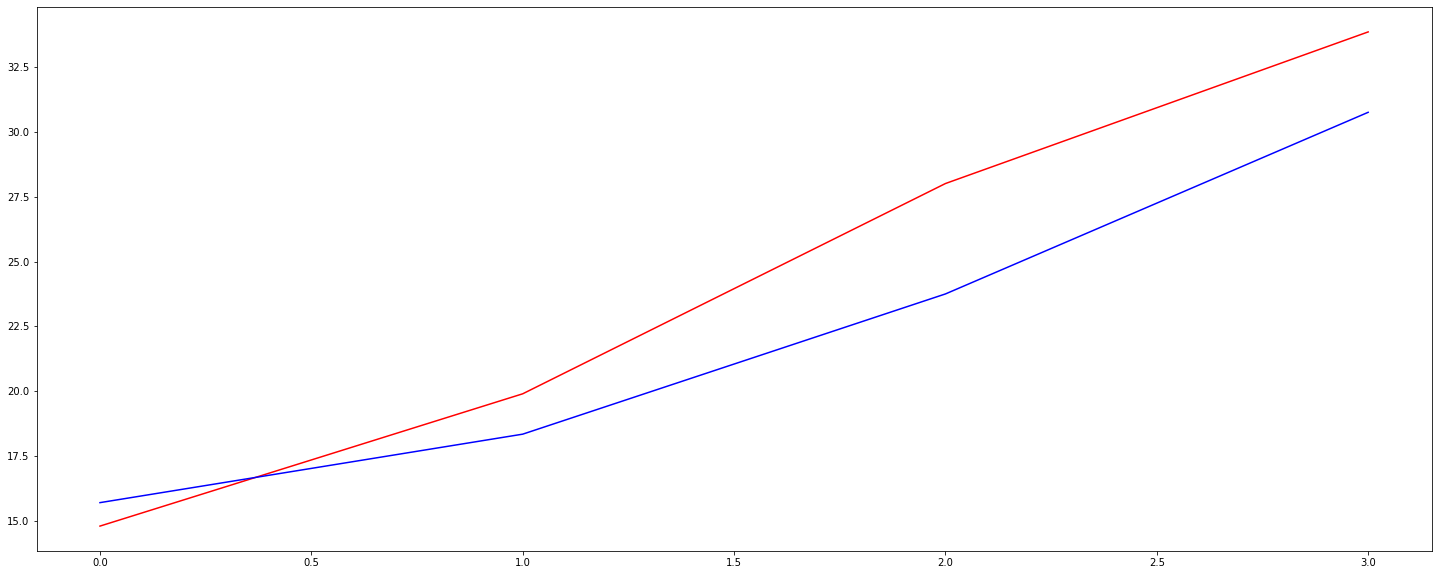

In [ ]:
# Plot predictions (red) vs test (blue)
# Predictions rely only on the last n_input months of train data; beyond that, the predictions are fed back into the model to make new predictions
plt.figure(figsize=(25,10))
plt.plot(range(len(test)), predictions[:len(test)], color="red")
plt.plot(range(len(test)), test["meantemp"], color="blue")

In [ ]:
# Calc RMSE using test (4 data points) and predictions (same number of data points)
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(test, predictions[:len(test)]))
print(f"RMSE: {round(rmse, 3)}")

RMSE: 2.781
